Simple NLBVP example
Have NLBVP
$$
\frac{1}{2}u u_x - \nu u_{xx} = f
$$
The solution for $f=f_\textrm{true}$ is $u_\textrm{true}$. This script finds $f_\textrm{true}$ by minimising
$$
\mathcal{J}=\|u-u_\textrm{true}\|^2
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Nx = 128

ncc_cutoff = 1e-6 # ncc_cutoff is imporant in this example
tolerance = 1e-16
dealias = 3/2
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.Chebyshev(coords['x'], size= Nx, bounds=(0, 1))
xbasis2 = xbasis.derivative_basis(2)
# Fields
u = dist.Field(name='u', bases=(xbasis,))
f = dist.Field(name='f', bases=(xbasis2,))
tau_u1 = dist.Field(name='tau_u1')
tau_u2 = dist.Field(name='tau_u2')

lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
dx = lambda A: d3.Differentiate(A,coords['x'])

# Substitutions
lift = lambda A,n: d3.Lift(A, lift_basis, n)
nu = 0.1
u_x = dx(u) + lift(tau_u1,-1)
# Problem
problem = d3.NLBVP([u,tau_u1,tau_u2], namespace=locals())
problem.add_equation("0.5*u*u_x - nu*dx(u_x) + lift(tau_u2,-1) = f")
problem.add_equation("u(x=0) = 0")
problem.add_equation("u(x=1) = 0")

In [2]:
pert_norm = np.inf
x, = dist.local_grids(xbasis)

f['g'] = np.sin(x*np.pi*2) # f_true
u['g'] = np.sin(x*np.pi*2) # initial guess for NLBVP

# # Solver
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)

while pert_norm > tolerance:
    solver.newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')

2023-08-10 12:52:21,109 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s
2023-08-10 12:52:21,111 __main__ 0/1 INFO :: Perturbation norm: 8.011e-01
2023-08-10 12:52:21,401 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2023-08-10 12:52:21,403 __main__ 0/1 INFO :: Perturbation norm: 6.371e-02
2023-08-10 12:52:21,437 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2023-08-10 12:52:21,438 __main__ 0/1 INFO :: Perturbation norm: 3.382e-04
2023-08-10 12:52:21,468 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2023-08-10 12:52:21,470 __main__ 0/1 INFO :: Perturbation norm: 1.314e-08
2023-08-10 12:52:21,500 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2023-08-10 12:52:21,502 __main__ 0/1 INFO ::

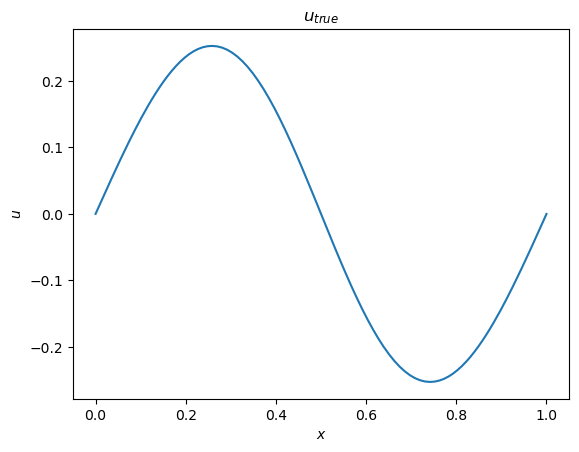

In [3]:
plt.plot(x,u['g'])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('$u_{true}$')
uTrue = u.copy()

In [4]:
from dedalus.tools import jacobi
# Get spectrally accurate weight matrices
a, b = xbasis.a, xbasis.b
integ_vector = jacobi.integration_vector(Nx, a, b)

W_field = u.copy_adjoint()

for i in range(Nx):
    W_field['c'][i] = 0.5*integ_vector[i]

In [5]:
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)

In [6]:
def directAdjointLoopGrid(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    f['g'] = forcing[:Nx]
    
    u['g'] = np.sin(2*np.pi*x)  
    tau_u1['g']=0
    tau_u2['g']=0
    
    pert_norm = np.inf

    while pert_norm > tolerance:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        
    # Check
    cost = 0.5*d3.integ(np.conj(u-uTrue)*(u-uTrue)).evaluate()['g'][0]
    solver.state_adj[0]['g'] = W_field['g']*(u['g']-uTrue['g'])
    
    solver.solve_adjoint()
    
    return cost, -solver.F_adj[0]['g']

In [7]:
pert_norm = np.inf
x, = dist.local_grids(xbasis)

f['g'] = x*(1-x)
u['g'] = np.sin(x*np.pi*2) 
tau_u1['g']=0
tau_u2['g']=0
# # Solver
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)

while pert_norm > tolerance:
    solver.newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
u0 = u.copy()

2023-08-10 12:52:22,079 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2023-08-10 12:52:22,081 __main__ 0/1 INFO :: Perturbation norm: 1.257e+00
2023-08-10 12:52:22,709 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2023-08-10 12:52:22,711 __main__ 0/1 INFO :: Perturbation norm: 4.172e-01
2023-08-10 12:52:22,795 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s
2023-08-10 12:52:22,797 __main__ 0/1 INFO :: Perturbation norm: 5.682e-02
2023-08-10 12:52:22,841 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-08-10 12:52:22,843 __main__ 0/1 INFO :: Perturbation norm: 6.483e-04
2023-08-10 12:52:22,876 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-08-10 12:52:22,878 __main__ 0/1 INFO ::

In [8]:
from scipy import optimize

opts = {'disp': True}
forcing = f['g']

sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True,options=opts,tol=1e-8)

2023-08-10 12:52:23,073 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+01/s
2023-08-10 12:52:23,075 __main__ 0/1 INFO :: Perturbation norm: 1.257e+00
2023-08-10 12:52:23,122 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-08-10 12:52:23,124 __main__ 0/1 INFO :: Perturbation norm: 4.172e-01
2023-08-10 12:52:23,171 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-08-10 12:52:23,173 __main__ 0/1 INFO :: Perturbation norm: 5.682e-02
2023-08-10 12:52:23,214 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-08-10 12:52:23,216 __main__ 0/1 INFO :: Perturbation norm: 6.483e-04
2023-08-10 12:52:23,244 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
2023-08-10 12:52:23,246 __main__ 0/1 INFO ::

 This problem is unconstrained.


2023-08-10 12:52:23,565 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2023-08-10 12:52:23,566 __main__ 0/1 INFO :: Perturbation norm: 5.269e-17

At iterate    1    f=  1.85630D-02    |proj g|=  1.86996D-03
2023-08-10 12:52:23,598 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-08-10 12:52:23,599 __main__ 0/1 INFO :: Perturbation norm: 1.032e+00
2023-08-10 12:52:23,645 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-08-10 12:52:23,647 __main__ 0/1 INFO :: Perturbation norm: 1.114e-01
2023-08-10 12:52:23,696 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-08-10 12:52:23,698 __main__ 0/1 INFO :: Perturbation norm: 1.040e-03
2023-08-10 12:52:23,733 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s

2023-08-10 12:52:25,035 __main__ 0/1 INFO :: Perturbation norm: 4.522e-17

At iterate    6    f=  2.18751D-05    |proj g|=  9.11228D-06
2023-08-10 12:52:25,065 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-08-10 12:52:25,067 __main__ 0/1 INFO :: Perturbation norm: 8.054e-01
2023-08-10 12:52:25,108 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-08-10 12:52:25,110 __main__ 0/1 INFO :: Perturbation norm: 6.361e-02
2023-08-10 12:52:25,149 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-08-10 12:52:25,150 __main__ 0/1 INFO :: Perturbation norm: 3.101e-04
2023-08-10 12:52:25,185 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2023-08-10 12:52:25,186 __main__ 0/1 INFO :: Perturbation norm: 1.625e-08
2023-08-10 12:52:25,221 subsystems 0/1 I

2023-08-10 12:52:26,445 __main__ 0/1 INFO :: Perturbation norm: 6.359e-02
2023-08-10 12:52:26,485 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-08-10 12:52:26,487 __main__ 0/1 INFO :: Perturbation norm: 3.289e-04
2023-08-10 12:52:26,522 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2023-08-10 12:52:26,523 __main__ 0/1 INFO :: Perturbation norm: 1.295e-08
2023-08-10 12:52:26,558 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-08-10 12:52:26,560 __main__ 0/1 INFO :: Perturbation norm: 5.516e-15
2023-08-10 12:52:26,596 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-08-10 12:52:26,598 __main__ 0/1 INFO :: Perturbation norm: 4.213e-17

At iterate   12    f=  3.30065D-06    |proj g|=  9.13011D-06
2023-08-10 12:52:26,626 subsystems 0/1 I

2023-08-10 12:52:27,847 __main__ 0/1 INFO :: Perturbation norm: 1.293e-08
2023-08-10 12:52:27,881 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-08-10 12:52:27,883 __main__ 0/1 INFO :: Perturbation norm: 1.166e-14
2023-08-10 12:52:27,917 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-08-10 12:52:27,919 __main__ 0/1 INFO :: Perturbation norm: 7.921e-17

At iterate   18    f=  5.46510D-07    |proj g|=  7.18293D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  128     18     21      1     0

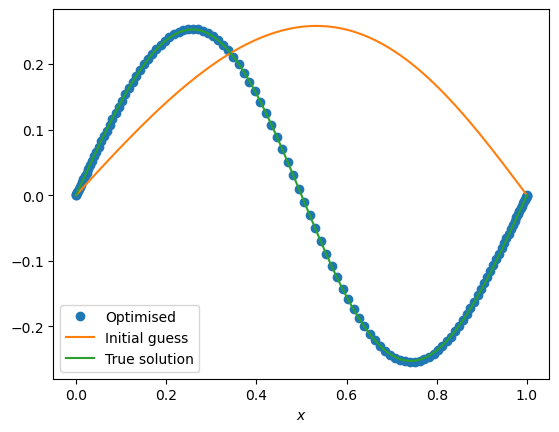

In [9]:
plt.plot(x,u['g'],'o',label='Optimised')
plt.plot(x,u0['g'],label='Initial guess')
plt.plot(x,uTrue['g'],label='True solution')
plt.xlabel('$x$')
plt.legend()

## Taylor test

In [10]:
forcing0 = np.sin(4*np.pi*x)
forcing1 = np.sin(6*np.pi*x)
cost0,grad0 = directAdjointLoopGrid(forcing0)
eps=0.01
costs = []
terms = []
epss = []
for i in range(10):
    epss.append(eps)
    costp,gradp = directAdjointLoopGrid(forcing0+eps*forcing1) 
    costs.append(costp)
    terms.append((costp-cost0)/eps)
    eps /=2

adj = np.vdot(grad0,forcing1)



2023-08-10 12:52:28,108 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-08-10 12:52:28,110 __main__ 0/1 INFO :: Perturbation norm: 1.031e+00
2023-08-10 12:52:28,144 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2023-08-10 12:52:28,145 __main__ 0/1 INFO :: Perturbation norm: 1.226e-01
2023-08-10 12:52:28,180 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-08-10 12:52:28,182 __main__ 0/1 INFO :: Perturbation norm: 1.745e-03
2023-08-10 12:52:28,212 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-08-10 12:52:28,214 __main__ 0/1 INFO :: Perturbation norm: 4.244e-07
2023-08-10 12:52:28,244 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2023-08-10 12:52:28,246 __main__ 0/1 INFO ::

2023-08-10 12:52:29,442 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-08-10 12:52:29,444 __main__ 0/1 INFO :: Perturbation norm: 2.241e-14
2023-08-10 12:52:29,475 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-08-10 12:52:29,477 __main__ 0/1 INFO :: Perturbation norm: 3.121e-17
2023-08-10 12:52:29,504 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+01/s
2023-08-10 12:52:29,506 __main__ 0/1 INFO :: Perturbation norm: 1.031e+00
2023-08-10 12:52:29,538 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-08-10 12:52:29,540 __main__ 0/1 INFO :: Perturbation norm: 1.226e-01
2023-08-10 12:52:29,572 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-08-10 12:52:29,574 __main__ 0/1 INFO ::

In [11]:
first_order  = np.abs(np.array(costs)-cost0)
second_order = np.abs(np.array(costs)-cost0-np.array(epss)*adj)

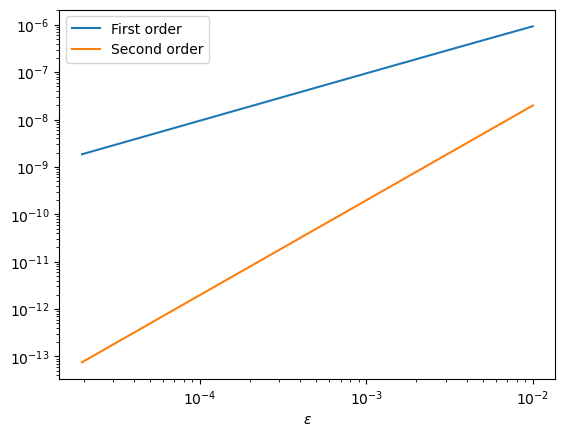

In [12]:
plt.loglog(epss,first_order,label=r'First order')
plt.loglog(epss,second_order,label=r'Second order')
plt.xlabel('$\epsilon$')
plt.legend()

In [13]:
from scipy.stats import linregress
print('######## Taylor Test Results ########')
print('First order  : ',linregress(np.log(epss), np.log(first_order)).slope)
print('Second order : ',linregress(np.log(epss), np.log(second_order)).slope)
print('#####################################')

######## Taylor Test Results ########
First order  :  0.9974086799068319
Second order :  2.0005340122012987
#####################################
